### Neural network 
scikit-learn 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# 1. Load data
# Skip header comments starting with '#'
df = pd.read_csv('data/renewables/pv_data.csv', comment='#', parse_dates=['time'])
df.rename(columns={'time': 'timestamp', 'electricity': 'pv_power'}, inplace=True)
df.set_index('timestamp', inplace=True)

In [5]:
# 2. Feature engineering: create lag features and time features
def create_features(data, lags=24):
    df_feats = pd.DataFrame(index=data.index)
    # lag features
    for lag in range(1, lags+1):
        df_feats[f'lag_{lag}'] = data['pv_power'].shift(lag)
    # time-based features
    df_feats['hour'] = data.index.hour
    df_feats['dayofyear'] = data.index.dayofyear
    df_feats['month'] = data.index.month
    # target
    df_feats['target'] = data['pv_power']
    return df_feats

lags = 24  # use previous 24h to predict next
feats = create_features(df, lags=lags)
feats.dropna(inplace=True)

In [6]:

# 3. Split into X and y
y = feats['target'].values
X = feats.drop(columns=['target']).values

# Use chronological split: train on first 80%, test on last 20%
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [7]:
# 4. Scale features and target
date_train = feats.index[:split_idx]
date_test = feats.index[split_idx:]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

In [8]:

# 5. Train MLPRegressor
mlp = MLPRegressor(
    hidden_layer_sizes=(100,50),
    activation='relu',
    solver='adam',
    random_state=42,
    max_iter=300
)
mlp.fit(X_train_scaled, y_train_scaled)

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)

In [9]:

# 6. Predict and invert scaling
y_pred_scaled = mlp.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

In [10]:

# 7. Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MAE: {mae:.3f} kW")
print(f"Test RMSE: {rmse:.3f} kW")

Test MAE: 0.015 kW
Test RMSE: 0.026 kW


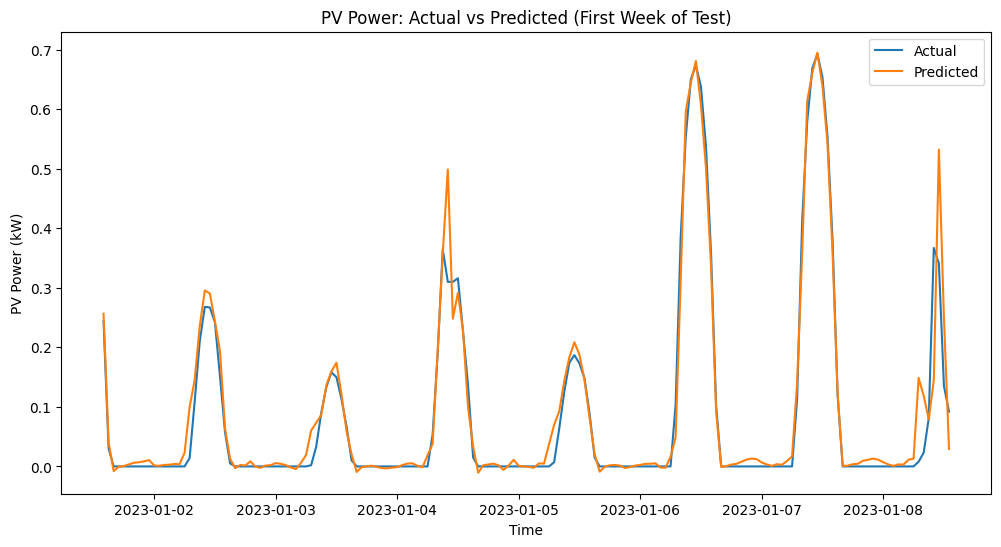

In [11]:

# 8. Visualization
plt.figure(figsize=(12, 6))
plt.plot(date_test[:168], y_test[:168], label='Actual')  # first week of test
plt.plot(date_test[:168], y_pred[:168], label='Predicted')
plt.xlabel('Time')
plt.ylabel('PV Power (kW)')
plt.title('PV Power: Actual vs Predicted (First Week of Test)')
plt.legend()
plt.show()

In [12]:
# 9. Forecast future horizon
# To forecast n steps ahead, iteratively feed predictions

def iterative_forecast(model, last_values, scaler_X, scaler_y, horizon=24):
    """
    last_values: array of last lag values, shape=(lags,)
    """
    forecast = []
    history = list(last_values)
    for _ in range(horizon):
        x_input = history[-lags:]
        # build feature vector
        features = []
        for lag in range(1, lags+1):
            features.append(history[-lag])
        # time features: assume continuing hourly
        next_time = df.index[-1] + pd.Timedelta(hours=len(forecast)+1)
        features.append(next_time.hour)
        features.append(next_time.dayofyear)
        features.append(next_time.month)
        X_in = np.array(features).reshape(1, -1)
        X_in_scaled = scaler_X.transform(X_in)
        y_out_scaled = model.predict(X_in_scaled)
        y_out = scaler_y.inverse_transform(y_out_scaled.reshape(-1,1)).ravel()[0]
        forecast.append(y_out)
        history.append(y_out)
    return forecast

# Example: forecast next day (24h)
last_lags = df['pv_power'].values[-lags:]
fcast = iterative_forecast(mlp, last_lags, scaler_X, scaler_y, horizon=24)
print("Next 24h forecast:", np.round(fcast, 3))


Next 24h forecast: [ 0.005  0.006  0.002  0.004  0.005  0.013  0.038  0.22   0.474  0.643
  0.728  0.742  0.682  0.548  0.329  0.073 -0.002  0.004  0.006  0.011
  0.011  0.013  0.019  0.019]
